In [2]:
#runs on the xesmf environment
import esmpy
import xarray as xr
import xesmf as xe
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from py_ecosystem import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.stats import spearmanr
import seaborn as sns


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#font
plt.rcParams['font.family'] = 'arial'

### Load data

In [3]:

# Open datasets with Dask and specify chunk sizes for parallel computing: each chunk is 100 time steps
p_const = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\psychrometric_constant_500m.nc")
Rn = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Rn_ROI_10km.nc")
delta = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\delta_10km.nc")

# Wind constants
wind_const_d = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\wind_const_d_10km.nc")
wind_const_n = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\wind_const_n_10km.nc")

# Read MODIS ET (500m)
modis_et = xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_ET_2000_2023.nc")

# Soil moisture content
# fldas_sm = xr.open_dataset(r"D:\VUB\_data\nc_files\fldas_sm.nc", chunks={'time': 100})
gldas_sm = xr.open_dataset(r"D:\VUB\_data\nc_files\gldas_SM_dataset.nc")
gleam_ds = xr.open_dataset(r"D:\VUB\_data\nc_files\gleam_daily_v41_2000_2023.nc")

# GPP
modis_gpp = xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_8day_Gpp_2000_2023.nc")
#modis_psnet = xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_8day_PsNet_2000_2023.nc")
glass_gpp = xr.open_dataset(r"D:\VUB\_data\nc_files\GLASS_gpp_2000_2021.nc")
plmv2_gpp = xr.open_dataset(r"D:\VUB\_data\nc_files\pml_v2_GPP_Ec.nc")

#rainfall
mswx_pcp = xr.open_dataset(r"D:\VUB\_data\nc_files\MSWX_daily_RF_2000_2023.nc")

#humidity
mswx_rh = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\RH_KE_data.nc")
mswx_rh = mswx_rh.sel(time=slice("2000-01-01", '2023-10-26'))
#vpd
mswx_vpd = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\VPD_10km.nc")

#temperature
mswx_tmax  = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Tmax_KE_data.nc")
mswx_tmin  = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Tmin_KE_data.nc")

mswx_tmean = (mswx_tmax.sel(time=slice("2000-01-01", '2023-10-26')) + mswx_tmin.sel(time=slice("2000-01-01", '2023-10-26')))/2

#modis lai
modisLAI = xr.open_dataset(r"D:\VUB\_data\nc_files\modis_terra_LAI_2000_2024.nc")

#co2
noa_co2 = xr.open_dataset(r"d:\VUB\_data\nc_files\co2_monthly_2000_2021.nc")

In [4]:
mswx_pcp = xr.open_dataset(r"D:\VUB\_data\nc_files\MSWX_daily_RF_2000_2023.nc")

In [5]:
modis_lst = xr.open_dataset(r"D:\VUB\_data\nc_files\modis_LST_8day_2000_2004.nc")

In [6]:
mswx_tmax.close(), mswx_tmin.close()

(None, None)

### Preprocessing

In [7]:
#rescale MODIS ET and remove nodata values
modis_et_values=modis_et.where(modis_et<32700)
modis_et_rescaled = modis_et_values*0.1

#modis_psnet_values=modis_psnet.where(modis_psnet<32700)
#modis_psnet_rescaled = modis_psnet_values*0.1

### Regridding using xESMF

> https://xesmf.readthedocs.io/en/stable/notebooks/Rectilinear_grid.html

In [8]:
# Define the desired resolution
resolution = 0.027  # Degrees

# Create the target grid with the new resolution
lat_start = p_const.lat.min()
lat_end = p_const.lat.max()
lon_start = p_const.lon.min()
lon_end = p_const.lon.max()

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat_start, lat_end + 0.5*resolution, resolution), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(lon_start, lon_end + 0.5*resolution, resolution), {"units": "degrees_east"}),
    }
)

In [9]:
#datasets to regrid
dataset_names = ['modis_et_out','mswx_rh_out' ,'modis_gpp_out', 'mswx_tmean_out', 'gldas_sm_out',
                'gleam_ds_out', 'mswx_pcp_out', 'mswx_vpd_out','p_const_out', 'Rn_out',
                'delta_out', 'wind_const_d_out', 'wind_const_n_out', 'modis_lai_out', 'modis_lst_out','noa_co2_out']

regridded_datasets = {}

datasets = [modis_et_rescaled, mswx_rh, modis_gpp, mswx_tmean, gldas_sm, gleam_ds, mswx_pcp, mswx_vpd,
             p_const, Rn, delta, wind_const_d, wind_const_n, modisLAI,modis_lst, noa_co2]


for dataset, dataset_name in zip(datasets, dataset_names):
    regridder = xe.Regridder(dataset, ds_out, 'bilinear')
    regridded_datasets[dataset_name] = regridder(dataset)

### Match data to MODIS frequency
> If correlations are to be determined using MODIS datasets, resample the frequency of the second dataset to match the time frequency of MODIS

### Calculate ETo

In [10]:
#numerator
n_ETo = (0.408 * regridded_datasets['delta_out']['air_temperature'] * regridded_datasets['Rn_out']['Rn'])
+ (regridded_datasets['p_const_out']['psychrometric_constant']*regridded_datasets['wind_const_n_out']) 

n_ETo = n_ETo.rename('n_ETo')

n_ETo=n_ETo.to_dataset()
#rename the variable
# var_name="".join( list(n_ETo.keys()))
#denominator
d_ETo=(regridded_datasets['delta_out']['air_temperature'] + regridded_datasets['p_const_out']['psychrometric_constant'] * regridded_datasets['wind_const_d_out'])
#rename the variable
d_var_name="".join( list(d_ETo.keys()))
d_ETo = d_ETo.rename({d_var_name:'d_ETo'})

ETo = n_ETo['n_ETo']/d_ETo['d_ETo']
ETo = ETo.rename('ETo')
ETo=ETo.to_dataset()

#close ETo inputs
inputs = [delta, wind_const_d, wind_const_n]

for input in inputs:
    input.close()

##### Aridity and water-use efficiency

In [11]:
modis_gpp_out_scaled = regridded_datasets['modis_gpp_out']['GPP']*0.0001
wue = modis_gpp_out_scaled/regridded_datasets['modis_et_out']['ET']
wue = wue.rename('WUE')
wue=wue.to_dataset()
#assign attributes
wue.attrs['long_name'] = 'Water Use Efficiency'
wue.attrs['units'] = 'kg C/m^2/mm'

In [12]:
aridty = regridded_datasets['mswx_pcp_out']['precipitation'] / ETo['ETo']

#### Evaporative Fraction

In [13]:
#evaporative fraction
# evap_frac = modis_et_monthly['ET']/(Rn_monthly['Rn'] * 0.408)
# evap_frac.name='evap_frac'
# evap_frac=evap_frac.to_dataset()

#### Timeseries of correlation

### Soil Moisture Regimes

In [14]:
# latitudinal_mean = gleam_ssm_me.mean(dim=['lat', 'time'])

# # Create the figure and axis
# fig, ax = plt.subplots(figsize=(10, 2.0))  # Swap figsize dimensions for a vertical plot
# ax.plot(latitudinal_mean['lon'], latitudinal_mean['SMs'], color='k', label='GLEAM RZSM')

# # Set labels
# ax.set_xlabel('lon')  # Now this is the x-axis label
# ax.set_ylabel('sm')    # This is the y-axis label

# # Add the legend
# ax.legend(loc='upper right')

# # Display the plot
# plt.show()


#### Spatial correlation and time lags

> Ensure the time frequencies of the datasets match


### Timeseries Lags: Vegetation response

> Seasonal Lags: Split the data according to seasonal occurence of rainfall
> Ensure the two datasets are on the same time frequency
>
>This section uses a series of functions in a specific order:  
  > 
> extract_grouped_data (output: xr.Dataset): matches the frequency of climate data to modis data  
> extract_region_timeseries (output: pd.DataFrame): from the grouped data extract timeseries of data averaged over a region  
> detect_season_onset (output: pd.datetime): from the region timeseries of precipitation, extract the onset of rainy seasons  
> veg_lag_correlation: (output pd.DataFrame): use the onset date to slice the veg_df and climate_df and calculate pearson r for different lag periods.

In [15]:
#define the datasets to be match with the modis dataset
modis_dataset = regridded_datasets['modis_gpp_out']
clima_dataset = regridded_datasets['gldas_sm_out']

#group clim data to match modis data
clima_grouped = extract_grouped_data(modis_dataset, clima_dataset, agg_func='mean')

In [16]:
#indepedent variable
hydr_var_name='SoilMoist_RZ_tavg'
veg_var_name='GPP'

#Investigate the effects of lagging vegetation response.
lag=0

min_lon, max_lon, min_lat, max_lat = 38, 39,1, 2

#extract the time series
veg_df=extract_region_timeseries(modis_dataset.sel(time=slice('2003-02-02','2021-12-31')), min_lon, max_lon, min_lat, max_lat)
hydr_df=extract_region_timeseries(clima_grouped.sel(time=slice('2003-02-02','2021-12-31')), min_lon, max_lon, min_lat, max_lat)

#visualize the time series
# fig,ax=plt.subplots(figsize=(11, 2.5))
# ax2=ax.twinx()
# veg_df[veg_var_name].shift(lag).plot(ax=ax, color='r')
# veg_df[veg_var_name].plot(ax=ax, color='g')
# hydr_df[hydr_var_name].plot(ax=ax2, color='k')

# print(veg_df[veg_var_name].shift(lag).corr(hydr_df[hydr_var_name]))

#### Rainfall: Detection of Rainy season onset

In [17]:
#function1: extract rainfall data by region
rainfall_df_daily = extract_region_timeseries(mswx_pcp, min_lon, max_lon, min_lat, max_lat)
rainfall_df_mon=rainfall_df_daily.resample('ME').sum()

#function2: extract daily accumulations of rainfall and detect the onset of the rainy season
daily_accumulated_rainfall, season_onset = detect_season_onset(rainfall_df_daily, threshold_rainy_days=10, cutoff_day=45)

#function3: slice the vegetation and climate using the detected onset of the rainy season
#compute the correlation between the vegetation response and hydrological variable, here soil moisture
corr_df = veg_lag_correlation(veg_df, hydr_df, range(-9, 1), season_onset, [3, 4, 5, 6, 7], 'GPP', 'SoilMoist_RZ_tavg')

#### Aggregated Monthly rainfall

In [18]:
monthly_df=[]
for yr in rainfall_df_mon.index.year.unique():
    daily_rf_by_yr=rainfall_df_mon[rainfall_df_mon.index.year==yr]
    rf_mon=daily_rf_by_yr.groupby(daily_rf_by_yr.index.month).sum()
    rf_mon.index=rf_mon.rename({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}).index
    rf_mon=rf_mon.iloc[:,[0]]
    rf_mon.columns=[yr]
    monthly_df.append(rf_mon)

# Create a DataFrame to store the monthly rainfall values
monthly_rainfall_df = pd.concat(monthly_df, axis=1)

short_season_months = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec']
long_season_months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']

short_season_rf=monthly_rainfall_df.loc[short_season_months]
long_season_rf=monthly_rainfall_df.loc[long_season_months]

#### Variance of rainfall

In [19]:
#calculate the variance of the rainfall
short_season_rf_var=short_season_rf.var(axis=0)
long_season_rf_var=long_season_rf.var(axis=0)

short_season_rf_var.mean(), long_season_rf_var.mean()

(1876.5094, 1671.603)

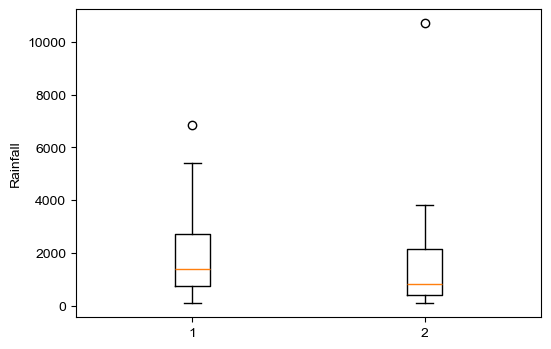

In [20]:
# Rainfall Dispersion
iqr_season1 = short_season_rf_var.quantile(0.75) - short_season_rf_var.quantile(0.25)
iqr_season2 = long_season_rf_var.quantile(0.75) - long_season_rf_var.quantile(0.25)

fig, ax = plt.subplots(figsize=(6, 4))
# Create box plot to compare the distributions
plt.boxplot([short_season_rf_var, long_season_rf_var])
plt.ylabel('Rainfall')
plt.show()


#### Lag correlation plots

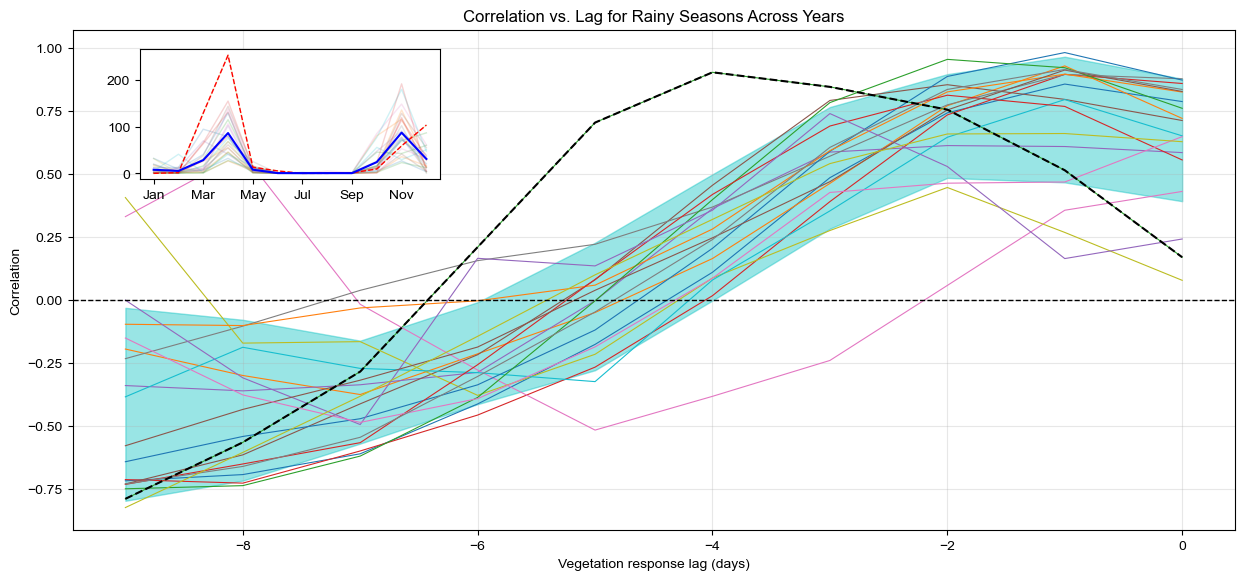

In [21]:
fig, ax = plt.subplots(figsize=(15, 6.5))

# Plot the correlations for each year
for year in corr_df.columns[:-4]: # Exclude the last 4 columns (mean, std_dev, etc.)
    plt.plot(corr_df.index, corr_df[year], lw=0.8, label=f'Year {year}')

# Plot a reference year (e.g., 2020) with a different style
plt.plot(corr_df.loc[:, 2005], ls='--', color='k', lw=1.5, label='Year 2020')

# Add shading between max and min correlations
ax.fill_between(corr_df.index, corr_df['mean_corr']-corr_df['std_dev_corr'], corr_df['mean_corr']+corr_df['std_dev_corr'], color='c', alpha=0.4, label='Range of Correlations')

plt.axhline(0., color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.xlabel('Vegetation response lag (days)')
plt.ylabel('Correlation')
plt.title('Correlation vs. Lag for Rainy Seasons Across Years')
#plt.legend(title='Year')
plt.grid(True, alpha=0.3)

#add rainfall plot as inset
"""
Define the position and size of the inset axes. 
This inset is located at 50% from the left and 15% from the bottom of the figure, and it occupies 30% of the figure’s width and height
"""
ax_inset = fig.add_axes([0.17, 0.65, 0.2, 0.2]) 
monthly_rainfall_df.plot(ax=ax_inset, lw=1.0, alpha=0.2,legend=False)
monthly_rainfall_df[2018].plot(ax=ax_inset, lw=1.0, alpha=1.0, c='r', ls='--', label='2005')
monthly_rainfall_df.mean(axis=1).plot(ax=ax_inset, lw=1.5, color='b', label='Mean')
ax_inset.set_xlabel('')
#ax_inset.set_ylabel('Rainfall (mm/month)')
plt.show()

#### Plotting Figures with cartopy

Ref: https://medium.com/@lubomirfranko/climate-data-visualisation-with-python-visualise-climate-data-using-cartopy-and-xarray-cf35a60ca8ee

In [22]:
"""
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load data
data = correlation_lagged

# Create a mask for no data (values less than 0.001 or NaNs)
no_data = (data < 0.001) | data.isnull()


# Set up the map projection and figure
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 8.5))
ax = plt.axes(projection=crs, frameon=True)

# Plot the correlation data with a color bar
cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.45, "pad": 0.05}
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr_r', cbar_kwargs=cbar_kwargs)

# Apply hatching for no data (NaN regions)
no_data_masked = np.ma.masked_where(~no_data, no_data)  # Mask the areas with data
ax.contourf(data.lon, data.lat, no_data_masked, transform=ccrs.PlateCarree(), colors='gray', hatches=['////'], alpha=0)
# Add coastlines
ax.coastlines()

# Draw gridlines and labels
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=0.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size": 7}
gl.ylabel_style = {"size": 7}

# Add lakes, rivers, and borders
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor='dodgerblue', linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), lw=0.7)

# Add the shapefile for Kenya counties
shapefile_path = r"E:\backup\backup_asus_pc\F\GIS Data\Counties of Kenya\County.shp"
shape_feature = ShapelyFeature(Reader(shapefile_path).geometries(),
                               crs=ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=0.2, alpha=0.4)
ax.add_feature(shape_feature)

ken_lakes=r"E:\backup\backup_asus_pc\F\GIS Data\KEN_Lakes\KEN_Lakes_4326.shp"
lake_feature = ShapelyFeature(Reader(ken_lakes).geometries(),
                               crs=ccrs.PlateCarree(), edgecolor='k', facecolor='skyblue', linewidth=0.2, alpha=1)
ax.add_feature(lake_feature)

# Set the map extent (latitude and longitude range)
lon_min = 35
lon_max = 39.5
lat_min = 0.0
lat_max = 4.0
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set the plot title
ax.set_title('Plot', fontsize=12)

# Show the plot
plt.show()

"""

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\kart\AppData\Local\Temp\ipykernel_22952\2698606652.py:1: SyntaxWarning: invalid escape sequence '\F'
  """


'\nimport cartopy.feature as cfeature\nfrom cartopy.io.shapereader import Reader\nfrom cartopy.feature import ShapelyFeature\n\n# Load data\ndata = correlation_lagged\n\n# Create a mask for no data (values less than 0.001 or NaNs)\nno_data = (data < 0.001) | data.isnull()\n\n\n# Set up the map projection and figure\ncrs = ccrs.PlateCarree()\nfig = plt.figure(figsize=(15, 8.5))\nax = plt.axes(projection=crs, frameon=True)\n\n# Plot the correlation data with a color bar\ncbar_kwargs = {\'orientation\': \'horizontal\', \'shrink\': 0.45, "pad": 0.05}\ndata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=\'bwr_r\', cbar_kwargs=cbar_kwargs)\n\n# Apply hatching for no data (NaN regions)\nno_data_masked = np.ma.masked_where(~no_data, no_data)  # Mask the areas with data\nax.contourf(data.lon, data.lat, no_data_masked, transform=ccrs.PlateCarree(), colors=\'gray\', hatches=[\'////\'], alpha=0)\n# Add coastlines\nax.coastlines()\n\n# Draw gridlines and labels\ngl = ax.gridlines(crs=crs, draw_labe

#### Spearman r

In [23]:
def spearman_r_1d(x, y):
    """Compute Spearman's rank correlation for two 1D arrays."""
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return np.nan  # Return NaN if all values are NaN
    return spearmanr(x, y, nan_policy='omit')[0]  # Omit NaNs and compute Spearman's rho

# # Apply the spearman_r_1d function over the 'time' dimension
# rho = xr.apply_ufunc(
#     spearman_r_1d,                      # Function to apply
#     modis_lagged[1:],                       # First variable
#     gldas_out_slice['SoilMoist_S_tavg'],                       # Second variable
#     input_core_dims=[['time'], ['time']],  # Core dimensions to operate over
#     vectorize=True,                     # Vectorize to apply over all lat/lon
#     dask='parallelized',                # Optional: parallelize with Dask
#     output_dtypes=[float]               # Output data type
# )

# rho.plot(cmap='bwr_r', vmin=-0.5, vmax=1.0)

### Extract timeseries for RandomForest Model

In [24]:
#define reference dataset
modis_dataset = regridded_datasets['modis_gpp_out']

#define region of extraction
min_lon, max_lon, min_lat, max_lat = 37., 38.5, 0, 0.7

#match frequency of the datasets with modis outputs: where the aggregation is a mean value
predictors_for_mean = [regridded_datasets['gleam_ds_out'][['S','SMrz','SMs']], regridded_datasets['gldas_sm_out'],
                       regridded_datasets['mswx_vpd_out'], regridded_datasets['mswx_tmean_out'],
                       regridded_datasets['mswx_rh_out'], regridded_datasets['modis_lai_out'],
                       regridded_datasets['modis_lst_out']]


dataset_avg_names = ['gleam_ds', 'gldas_sm', 'mswx_vpd', 'mswx_tmean', 'mswx_rh', 'modisLAI', 'modis_lst']

datasets_grouped_mean = {}
for name,dataset in zip(dataset_avg_names,predictors_for_mean):
    dataset = extract_grouped_data(modis_dataset, dataset, agg_func='mean')
    datasets_grouped_mean[name] = dataset

"""compute for sum variables """
#predictor datasets with aggregation by summation
predictors_for_sum = [regridded_datasets['mswx_pcp_out'], regridded_datasets['Rn_out'], 
                      ETo, regridded_datasets['modis_gpp_out'],regridded_datasets['gleam_ds_out'][['E']]]

dataset_sum_names = ['mswx_pcp', 'Rn', 'ETo', 'modis_gpp','E']


datasets_grouped_sum = {}
for name,dataset in zip(dataset_sum_names,predictors_for_sum):
    dataset = extract_grouped_data(modis_dataset, dataset, agg_func='sum')
    datasets_grouped_sum[name] = dataset

#combine the datasets
##Using ** [double star] is a shortcut that allows you to pass multiple arguments to a function directly using a dictionary
combined_datasets = {**datasets_grouped_mean, **datasets_grouped_sum}

#### Extract timeseries of features and Label

To increase the sample size, sample over various locations and combine.
In this case, timeseries from 5 ROIs have been sampled and concatenated into a single time series

In [25]:
#for each variable, extract the time series for the region of interest
#extract 4 sub-ROIs from the region bound by the min and max lat and lon
lats = np.arange(min_lat, max_lat, 0.04)
lons = np.arange(min_lon, max_lon, 0.04)

#extract the time series for each variable
df_ML= list()

for ds in combined_datasets:
    #list to store the extracted dataframe for each variable for combined ROIs
    ds_combined = list()

    for i in range(len(lats)-1):
        #extract the feature data
        df_region=extract_region_timeseries(combined_datasets[ds], lons[i], lons[i+1], lats[i], lats[i+1])
        
        #xtract the Label data
        y_WUE = extract_region_timeseries(wue,lons[i], lons[i+1], lats[i], lats[i+1])

        #concatenate the dataframes
        df_feature_label = pd.concat([df_region, y_WUE], axis = 1)
        ds_combined.append(df_feature_label)

    #for each variable, combine the feature and label for all ROIs
    df_region_fl = pd.concat(ds_combined, axis = 0)
    
    #append each variable to the list of predictors
    df_ML.append(df_region_fl)

# #combine the dataframes
combined_predictor_df = pd.concat(df_ML, axis=1)
# combined_predictor_df = combined_predictor_df.dropna()

In [59]:
combined_predictor_df = pd.concat(df_ML, axis=1)
# #compute bulk surface resistance (100/(0.5*LAI)). The LAI is scaled by a factor of 0.1 from the original dataset
combined_predictor_df['bulk_resistance'] = 100/(0.5*combined_predictor_df['LAI']/10)

data = combined_predictor_df.drop(columns=['SoilMoist_RZ_tavg', 'SoilMoist_S_tavg'])
data = data.dropna()

In [60]:
# Find rows where bulk_resistance is greater than mean + 4*std (outliers)
outliers = data[data['bulk_resistance'] > data['bulk_resistance'].mean() + 8 * data['bulk_resistance'].std()]

# Print the index and flag as outlier
if not outliers.empty:
    for index in outliers.index:
        print(data.loc[index, 'bulk_resistance'])
else:
    print("No outliers found")

# Remove the outliers from the dataset
data = data.drop(outliers.index)

No outliers found


In [28]:
#include data from previous time for target variable
data['WUE_t-1'] = data['WUE'].iloc[:,0].shift(1)
#data['stress_deg_days'] = data['LST'] - data['air_temperature']
data = data.dropna()

##### Monthly data 
> Since the $CO_{2}$ data is available monthly, the rest of the features are resampled to monthly frequency

##### Extract Monthly $CO_{2}$ timeseries

In [29]:
#extract the co2 timeseries for each ROI
co2_roi_list = list()
co2_ts = regridded_datasets['noa_co2_out']['co2'].sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon)).mean(dim=['lat', 'lon'])
co2_df = co2_ts.to_dataframe().drop(columns=['level'])
co2_df_mon = co2_df.resample('ME').mean()

for i in range(len(lats)-2):
    co2_roi_list.append(co2_df_mon)
co2_mon_df = pd.concat(co2_roi_list, axis=0)

In [30]:
data_monthly = data.resample('ME').mean()
data_ML_mon = pd.concat([data_monthly, co2_df_mon], axis=1).dropna()

#### Multicollinearity: Variance Inflation Factor
VIF is a statistical measure that quantifies the degree of multicollinearity for each predictor variable in a regression model. When two or more predictor variables are highly correlated, VIF assesses how much the variance of an estimated regression coefficient is inflated due to this correlation. A high VIF indicates that the variable is redundant or strongly related to other predictors, leading to instability in the regression model.  

The variance inflation factor is a measure of the increase of the variance of the parameter estimates if an additional variable, given by exog_idx is added to the linear regression. It is a measure for multicollinearity of the design matrix, exog.  

High correlation between predictor variables, can create instability and bias in regression models.

Mathematically, VIF for a predictor variable 𝑋𝑖 is defined as:

The Variance Inflation Factor (VIF) for a predictor variable  $X_i$ is calculated using the formula:


$$ VIF(X_{i}) = \frac{1}{1 - R_{i}^2 }$$

where $R_{i}^2$ is the coefficient of determination obtained by regressing the predictor $X_{i}$ on all the other predictor variables.

The way to calculate a VIF for the predictors is to create an auxilliary regression on each of them against all the other predictor variables:

$$X_{i} = \beta_{0}^* + \beta_{1}^*X_{i+1} + \beta_{2}^*X_{i+2} +...+ \beta_{p-1}^*X_{p} + \epsilon$$ 
and so on for the other predictor variables.  
​
By running this regression, a value of $R_{i}^2$ for the specific variable which tells how well that variable is described/explained  by movements in the other variables (how much of its information is carried by the other variables) and hence the degree of its multicollinearity.


In [31]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import statsmodels.api as sm

# # Extract predictor variables (excluding the target variable)
# X = combined_predictor_df#[['E','Rn','SMrz','VPD']]

# # Calculate VIF for each predictor variable
# vif = pd.DataFrame()
# vif['Variable'] = X.columns
# vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Display variables with VIF > 5
# #print(vif)

In [32]:
# X = data_monthly.drop(columns = ['WUE'])
# y = data_monthly['WUE'].iloc[:,0]

In [33]:
# data['relative_humidity'] = data['relative_humidity']/100

#### Random Forest Regression

GridSearchCV: Exhaustive search over specified parameter values for an estimator by implementing a fit and score method.  
Parameters are optimized by cross-validated grid-search over a parameter grid.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

"""-----------------------------------Random Forest Regressor---------------------------------------------"""

X = data.drop(columns = ['WUE','relative_humidity','GPP','WUE_t-1'])
y = data['GPP']#.iloc[:,0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


param_grid = {
    'n_estimators': [150],        # Number of trees in the forest
    'max_depth': [35],              # Maximum depth of each tree
    'min_samples_split': [3],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2],         # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=5,                        # Number of cross-validation folds
    n_jobs=-1,                   # Number of jobs to run in parallel
    scoring='neg_mean_squared_error' # Strategy to evaluate the performance of the cross-validated model on the test set.
)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")


# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
nse = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))

Best parameters: {'max_depth': 35, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 150}


R^2:0.933, RMSE:35.17, NSE:0.933



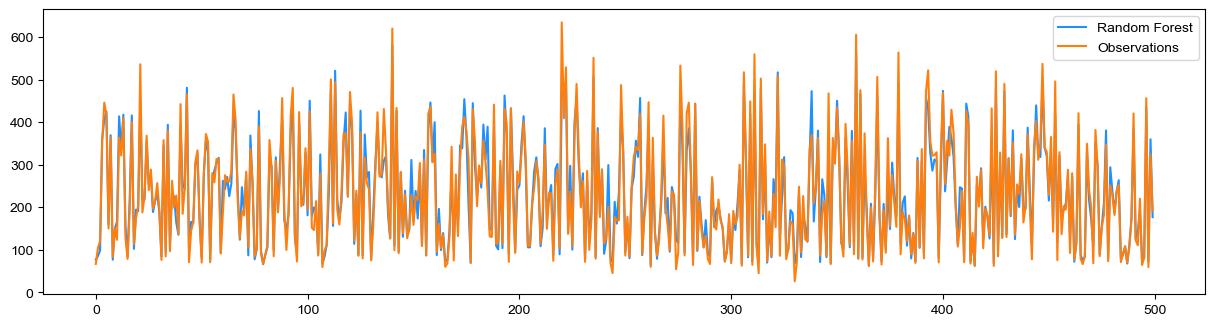

In [35]:
#plot the results vs the observed values
plt.figure(figsize=(15, 3.7))
plt.plot(y_pred[200:700], color='dodgerblue', lw=1.5, label='Random Forest')
plt.plot(y_test[200:700].values, color='C1', lw=1.5, label='Observations')
print(f"R^2:{np.round(r2, 3)}, RMSE:{np.round(rmse, 2)}, NSE:{np.round(nse, 3)}")
print()
#fill 95% confidence interval
# plt.fill_between(np.arange(0,len(y_test[600:900])), y_pred[600:900]-2*rmse, y_pred[600:900]+2*rmse, color='gray', alpha=0.2)

plt.legend()

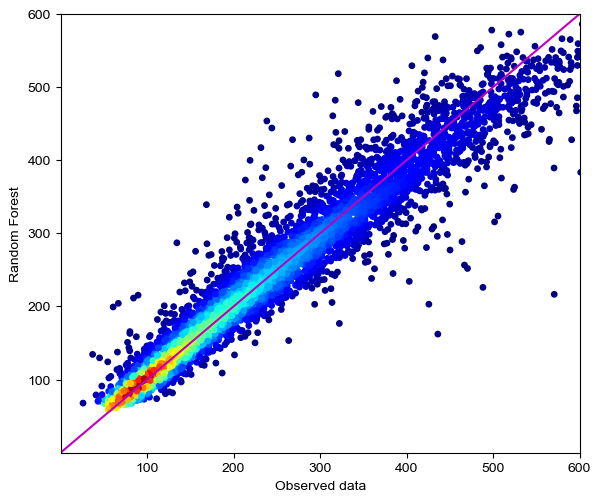

In [36]:
# Calculate the point density
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,y_pred])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(6.7, 5.7))
ax.scatter(y_test, y_pred, c=z, s=15, cmap='jet', alpha=1.0)
ax.plot([0, y_test.max()], [0, y_test.max()], 'm-', lw=1.5)
ax.set_xlim(.00015, y_pred.max())
ax.set_ylim(.00015, y_pred.max())

ax.set_xlabel('Observed data')
ax.set_ylabel('Random Forest')
plt.show()

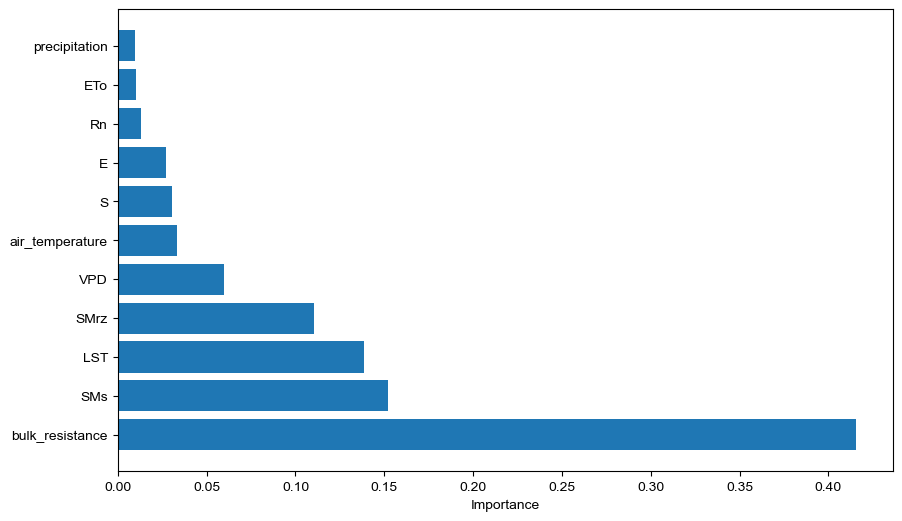

In [37]:
#calculate the feature importance
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame(feature_importance, index=X.columns, columns=['Importance'])

# Sort the values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df.index, feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.show()

#### SHAPley Values

SHAP (SHapley Additive exPlanations) values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each player's contribution to the final outcome. In machine learning, each feature is assigned an importance value representing its contribution to the model's output.

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.

In [38]:
import shap

# Create an explainer object
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

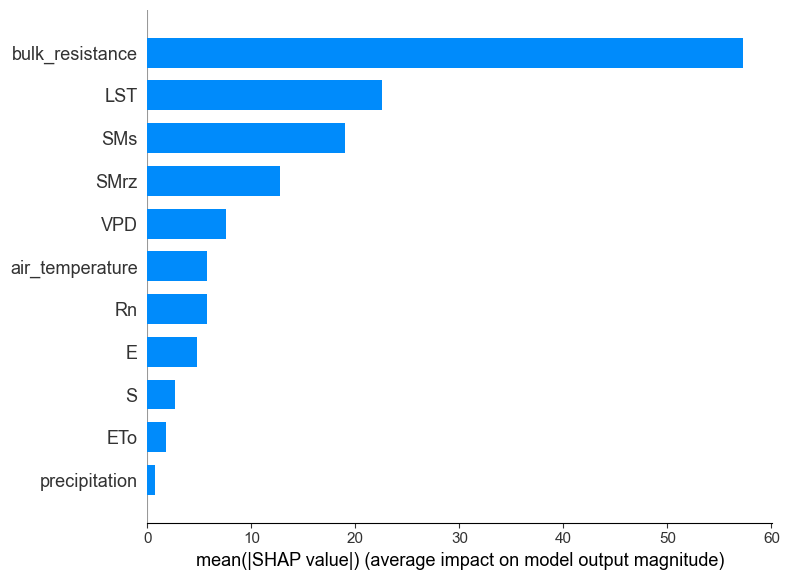

In [39]:
#Label according to the feature labels
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

In [40]:
#regression Tree
from sklearn.tree import plot_tree

# Extract the first tree from the random forest
tree = best_model.estimators_[0]

#plt.figure(figsize=(15, 10), dpi=200)

# plot_tree(best_model.estimators_[0], feature_names=X.columns, filled=True, impurity=False, fontsize=6);

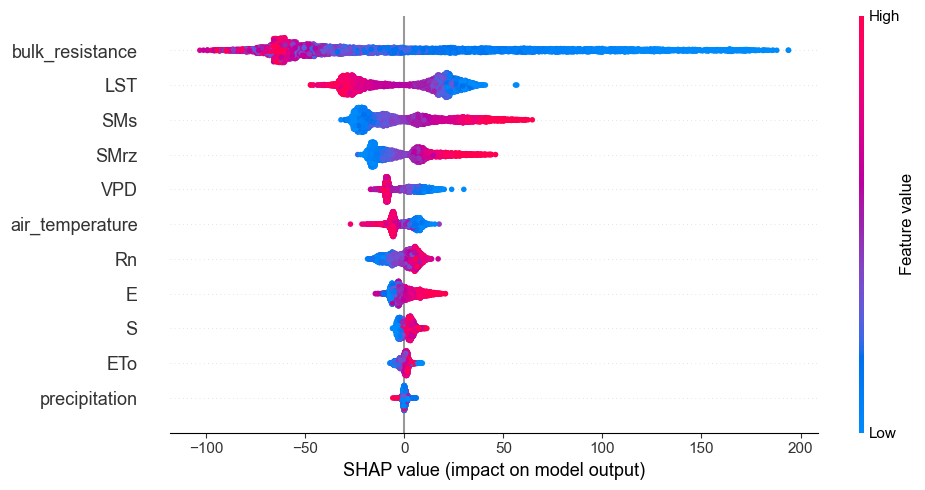

In [41]:
# Generate the SHAP beeswarm plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns,plot_size=[10,5])

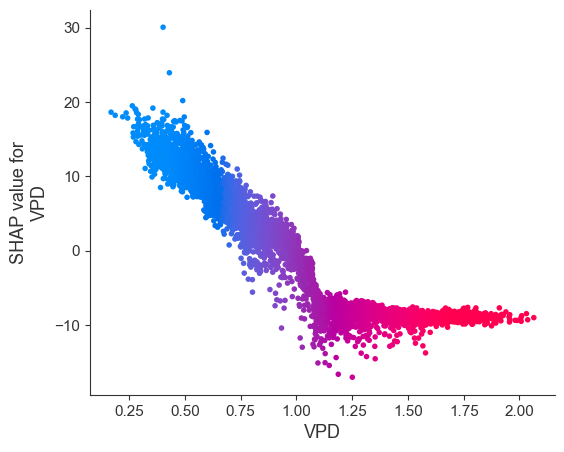

In [42]:
shap.dependence_plot("VPD", shap_values, X_test, feature_names=X.columns, interaction_index='VPD')

(-0.1, 0.5)

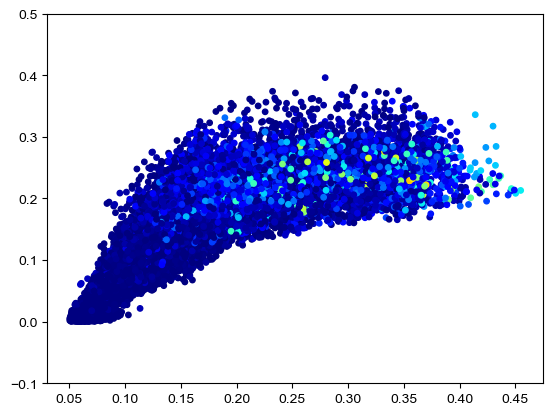

In [43]:
plt.scatter(data['SMs'], (data['E']/data['Rn']), cmap='jet', c=data['precipitation'], s=15)
plt.ylim(-0.1, 0.5)

In [44]:
stress_deg_days = data['LST'] - data['air_temperature']

In [45]:
stress_deg_days

time
2000-03-05    10.598511
2000-03-13    10.459003
2000-03-21     9.339706
2000-04-14     6.894184
2000-04-22     6.027147
                ...    
2023-09-22    10.609879
2023-09-30    11.332165
2023-10-08    12.102098
2023-10-16     6.534794
2023-10-24     5.489386
Length: 16693, dtype: float32

### Trends

In [46]:
#calculate the theil-sen estimator
import pymannkendall as mk
from scipy.stats import theilslopes
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor

In [47]:
mon_WUE_data = data['precipitation'].resample('D').sum().dropna()

months = np.arange(3, 7)

# #extract the data for the months of interest
#mon_WUE_data = mon_WUE_data[mon_WUE_data.index.month.isin(months)]

#mon_WUE_data = mon_WUE_data.groupby(mon_WUE_data.index.year).sum()

# Calculate the Mann-Kendall test statistic and p-value
mk_result = mk.original_test(mon_WUE_data.rolling(window=2).mean())
print(f"{mk_result.trend}, p-value:, {mk_result.p}")

increasing, p-value:, 0.003726181819985186


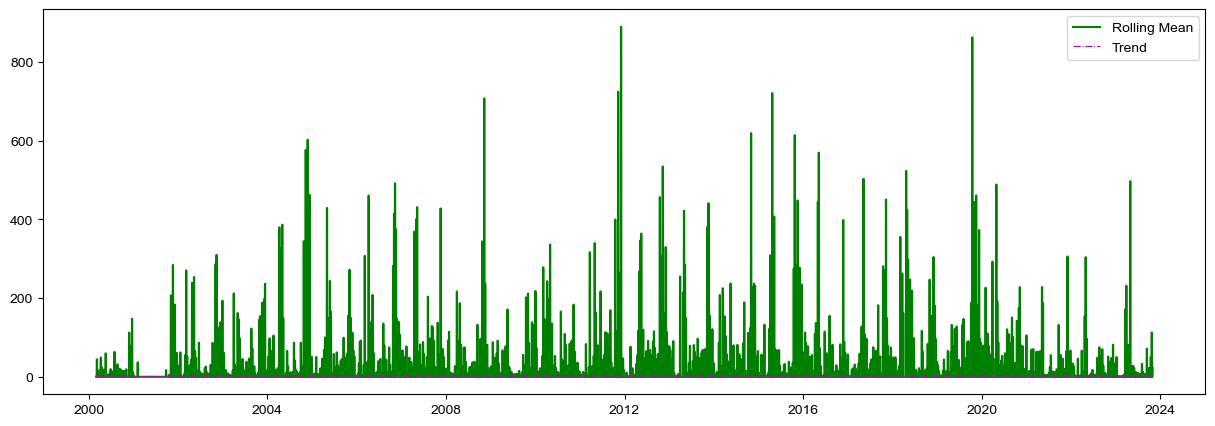

In [48]:
# Calculate the slope line
slope_line = mk_result.slope * np.arange(len(mon_WUE_data)) + mk_result.intercept

# Convert slope line to a DataFrame with the same index as data
slope_line_df = pd.DataFrame({'slope_line': slope_line}, index=mon_WUE_data.index)

# Create the rolling mean of the data (12-month window)
rolling_mean = mon_WUE_data.sort_index().rolling(window=3).mean()

# Plot the rolling mean and the trend line
fig, axis = plt.subplots(figsize=(15, 5))
axis.plot(rolling_mean, color='g', label='Rolling Mean')
axis.plot(slope_line_df, 'm-.', label='Trend', linewidth=0.8)
axis.legend()

plt.show()

### Seasonal Trends

In [49]:
#for each dataset, extract the long and short rainy season data
#extract the long rainy season data
long_rainy_season = data.loc[data.index.month.isin([3, 4, 5, ])]
short_rainy_season = data.loc[data.index.month.isin([10, 11, 12])]

### Inherent WUE
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2008GB003233

$$IWUE = \frac{GPP * VPD}{ET}\$$  

Computed at the Ecosystem Level. The dependence of IWUE* on
environmental conditions indicates possible adaptive adjustment of ecosystem physiology
in response to a changing environment. Under steady state environmental conditions, the rate
of carbon assimilation (A) equals the rate of diffusion of
CO2 molecules into the leaf, and the rate of transpiration (E)
equals the rate of diffusion of H2O molecules out of the leaf


In [64]:
iwue = regridded_datasets['modis_lai_out'].resample(time = 'ME').mean()

# Create a mask for cells that have NaN values along the time dimension
valid_mask =  iwue.notnull().all(dim='time')

def preprocessed_mann_kendall(dataset):
    # Convert the input to a NumPy array
    data = np.array(dataset)
    
    # Remove NaN values
    data_nonan = data[~np.isnan(data)]
    
    # Check if there are enough valid data points for the trend analysis
    if len(data_nonan) > 1:
        try:
            # Apply the Mann-Kendall test at the 95% confidence level
            #Since the data is repeating, use the seasonal MK test with a period of 12 for monthly data
            result = mk.seasonal_test(data_nonan, period=12)
            
            # Check if the trend is significant
            if result.p <= 0.05:
                # Return the Theil-Sen estimator slope
                return result.slope
            else:
                return np.nan  # No significant trend
        except Exception as e:
            # Handle any exceptions that occur during the trend analysis
            print(f"Error encountered: {e}")
            return np.nan
    else:
        # Not enough valid data points
        return np.nan

mk_result = xr.apply_ufunc(
    preprocessed_mann_kendall, iwue.where(valid_mask)['LAI'][0:],
    input_core_dims=[['time']], 
    vectorize=True, dask='parallelized',
    output_dtypes=[float]
)

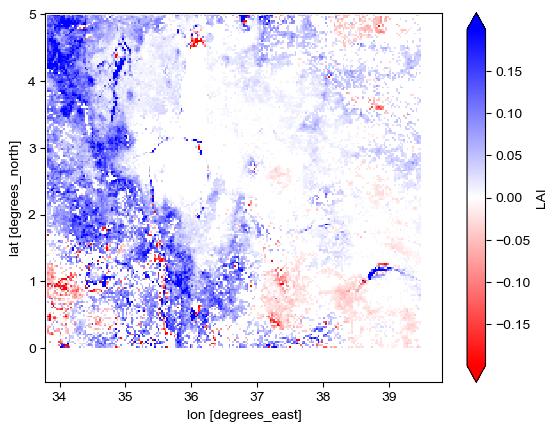

In [68]:
mk_result.plot(cmap='bwr_r', robust=True)

In [63]:
mk_result

<xarray.DataArray 'LAI' (lat: 205, lon: 223)> Size: 366kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 0.09729956, 0.12091057, ...,        nan,        nan,
               nan],
       [       nan, 0.09971782, 0.11644577, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 2kB -0.4994 -0.4724 -0.4454 ... 4.955 4.982 5.009
  * lon      (lon) float64 2kB 33.8 33.83 33.85 33.88 ... 39.74 39.77 39.79